In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation

# Import Data

In [2]:
data = pd.read_csv("compare.csv", sep = ",")
movella = pd.read_csv("free_acc.csv", skiprows = 10, sep = ",")
movella.head()
# data.columns

,PacketCounter,SampleTimeFine,Euler_X,Euler_Y,Euler_Z,FreeAcc_X,FreeAcc_Y,FreeAcc_Z,Gyr_X,Gyr_Y,Gyr_Z
0,1,886546881,-0.577381,0.833098,120.532089,0.002496,-0.004901,0.516185,-0.034298,-0.041075,0.026961
1,2,886563548,-0.562597,0.844677,120.519684,0.004677,0.000934,0.510784,0.857264,0.495241,1.249266
2,3,886580215,-0.551584,0.855273,120.528786,0.008589,0.008239,0.538848,0.772959,0.488095,1.225843
3,4,886596882,-0.542827,0.863296,120.531555,0.006474,0.006186,0.522942,0.825427,0.457629,1.241928
4,5,886613549,-0.534495,0.870943,120.512062,0.008578,0.014289,0.505388,0.828603,0.474712,1.219260


In [3]:
acc = np.array([data["Acc_X"], data["Acc_Y"], data["Acc_Z"]])
gyr = np.array([data["Gyr_X"], data["Gyr_Y"], data["Gyr_Z"]])
# mag = np.array([data["Mag_X"], data["Mag_Y"], data["Mag_Z"]])
q = np.array([data["Quat_X"], data["Quat_Y"], data["Quat_Z"], data["Quat_W"]])
free_acc = np.array([movella["FreeAcc_X"], movella["FreeAcc_Y"], movella["FreeAcc_Z"]])

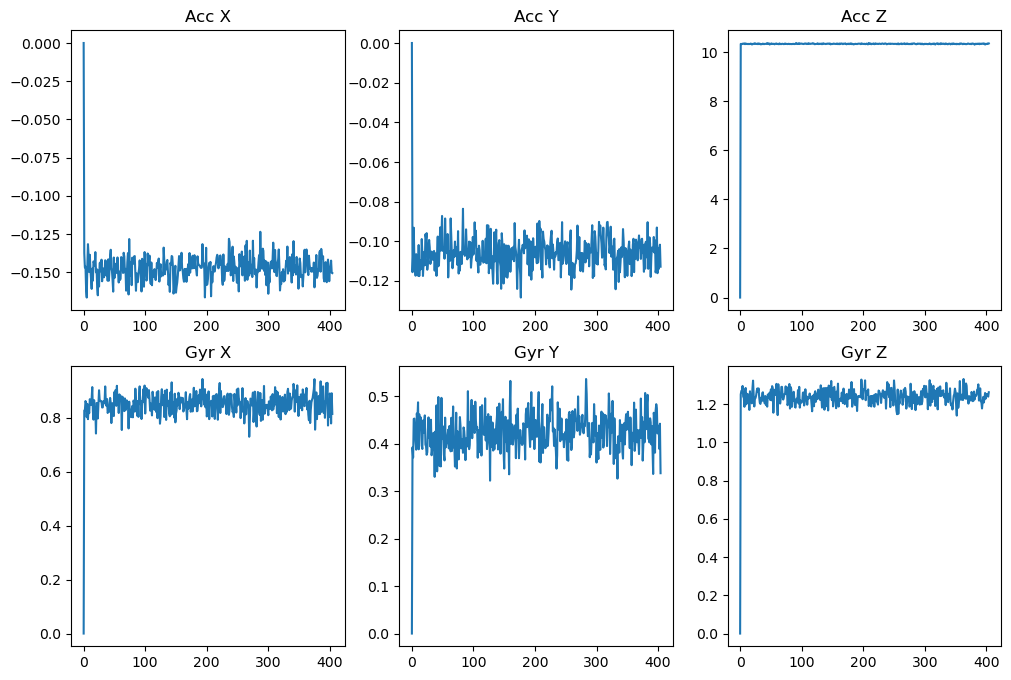

In [4]:
# Plotting raw data
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
plt.subplots_adjust(hspace=0.2)

for i in range(3):
    axs[0, i].plot(acc[i])
    axs[0, i].set_title(f'Acc {["X", "Y", "Z"][i]}')

    axs[1, i].plot(gyr[i])
    axs[1, i].set_title(f'Gyr {["X", "Y", "Z"][i]}')

plt.show()

# Gravity Compensation

In [7]:
def array2quat(array):
    """ 
    Reshape quaternion data to have each quaternion as a row
    [qX, qY, qZ, qW], [qX1, qY1, qZ1, qW1], ...
    :param array quaternion array to be converted
    """
    num_quaternions = len(array[0])
    quat = np.zeros((num_quaternions, 4))
    for i in range(num_quaternions):
        quat[i] = [array[0][i], array[1][i], array[2][i], array[3][i]]
    return quat

def array2acc(array):
    """
    Reshape acceleration data to have all axes acceleration in a row
    [ax, ay, az], [ax1, ay1, az1], ...
    """
    num_acc = len(array[0])
    acc_data = np.zeros((num_acc, 3))
    for i in range(num_acc):
        acc_data[i] = [array[0][i], array[1][i], array[2][i]]
    return acc_data

def acc2array(acc):
    """
    Reshape acceleration data to have separate arrays for each axes
    [x, x1, x2, ...], [y, y1, y2, ...], [z, z1, z2, ...]
    """
    num_acc = len(acc)
    acc_x = np.zeros(num_acc)
    acc_y = np.zeros(num_acc)
    acc_z = np.zeros(num_acc)
    for i in range(num_acc):
        acc_x[i] = acc[i][0]
        acc_y[i] = acc[i][1]
        acc_z[i] = acc[i][2]  
    return np.array([acc_x, acc_y, acc_z])

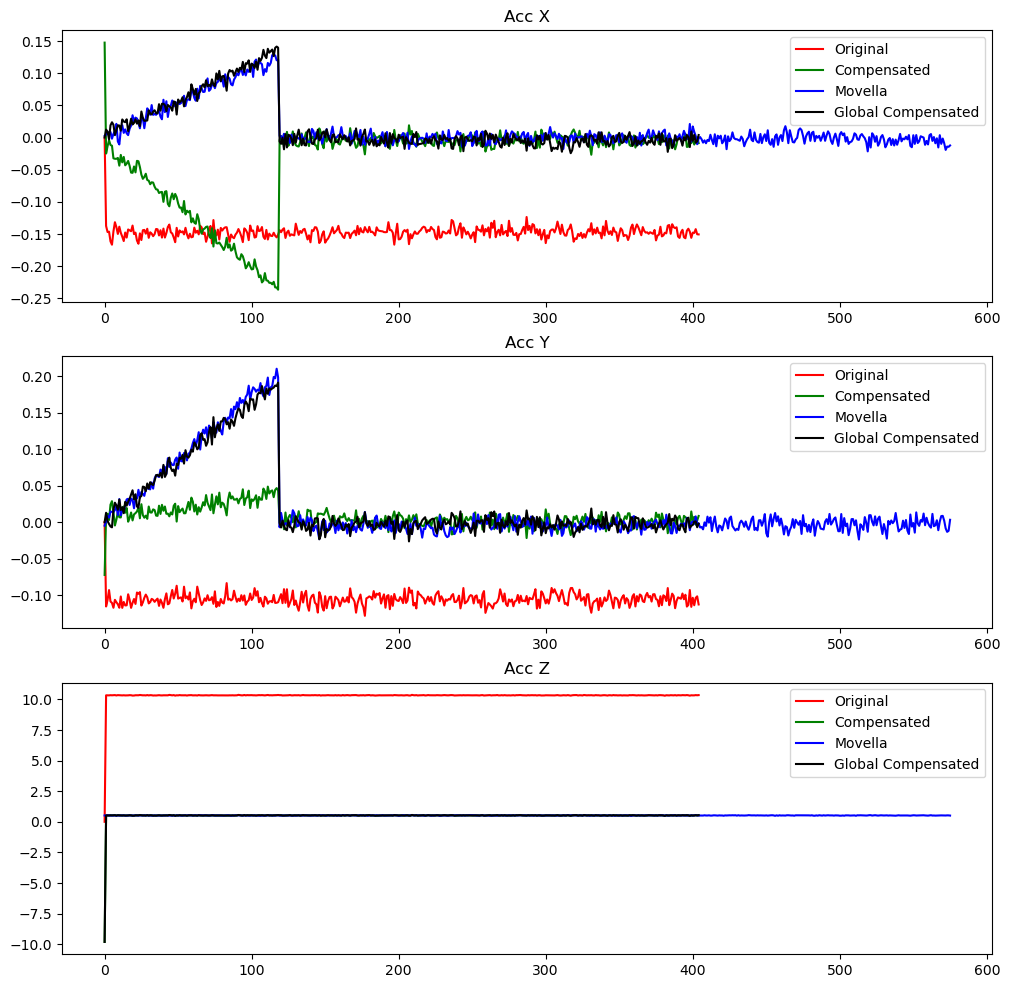

In [8]:
num = len(acc[0])
quat = array2quat(q)
acc_data = array2acc(acc)

# Gravitation as array [x, y, z]
g = np.array([0, 0, 9.81])

# Create global matrix using quaternions
acc_global = np.zeros((num, 3))
for i in range(num):
    # Quaternions to Rotation matrix
    r = Rotation.from_quat(quat).as_matrix()
    # Multiply R with measured acceleration
    acc_global[i] = np.dot(r[i], acc_data[i])

# Subtract gravitation from global acceleration
acc_global_comp = acc_global - g

# Rotate back to IMU frame
acc_comp = np.zeros((num, 3))
for i in range(num):
    # Quaternions to Rotation matrix
    r = Rotation.from_quat(quat).as_matrix()
    # Multiply R with measured acceleration
    acc_comp[i] = np.dot(r[i], acc_global_comp[i])
    
# Convert for plotting
acc_comp = acc2array(acc_comp) 
acc_global_comp = acc2array(acc_global_comp)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
plt.subplots_adjust(hspace=0.2)

# Plotting accelerometer data and compensated data
for i in range(3):
    axs[i].plot(acc[i], color='red', label='Original')
    axs[i].plot(acc_comp[i], color='green', label='Compensated')
    axs[i].plot(free_acc[i], color='blue', label='Movella')
    axs[i].plot(acc_global_comp[i], color='black', label='Global Compensated')
    axs[i].set_title(f'Acc {["X", "Y", "Z"][i]}')
    axs[i].legend()

plt.show()